# setup and installing dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

You should consider upgrading via the 'D:\facial_recognition\facialreco\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import random
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D,Input,Flatten

In [4]:
#creating folder structure 
pos_path = os.path.join('data','positive')
neg_path = os.path.join('data','negative')
anc_path = os.path.join('data','anchor')


In [7]:
os.makedirs(pos_path)
os.makedirs(neg_path)
os.makedirs(anc_path)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# collecting positives and anchor

In [5]:
import uuid # this will help in generating unique image names

In [2]:
# https://vis-www.cs.umass.edu/lfw/
#uncompressed tar GZ file containing dataset
!tar -xf lfw.tgz

In [9]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        ex_path = os.path.join('lfw',directory,file)
        new_path = os.path.join(neg_path,file)
        os.replace(ex_path,new_path)

In [5]:
#setting webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #cut down frame to 250x250 px
    frame = frame[120:120+250,200:200+250,:]
    #collecting anchors
    if cv2.waitKey(1)&0XFF==ord('a'):
        imgname = os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    #collecting positves
    if cv2.waitKey(1)&0XFF==ord('p'):
        imgname = os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    cv2.imshow("image collection",frame)
    #plt.imshow(frame)
    if cv2.waitKey(1) & 0XFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# load and preprocessing images


In [6]:
anchor = tf.data.Dataset.list_files(anc_path+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(pos_path+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(neg_path+'\*.jpg').take(300)


In [7]:
dir_test = anchor.as_numpy_iterator()
dir_test.next()

b'data\\anchor\\5fd2f0c0-64f4-11ee-98c1-d8c0a6948b76.jpg'

In [8]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0  #scale image to be between 0 and 1
    return img

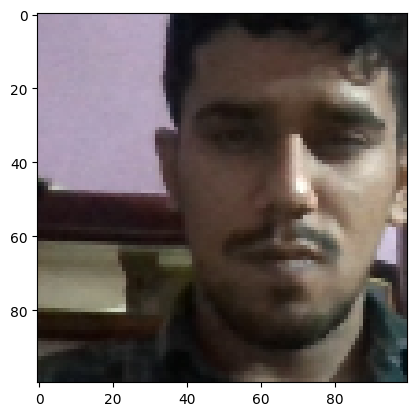

In [9]:
#testing of fucntion
ig = preprocess('data\\anchor\\694c1043-64f4-11ee-ae95-d8c0a6948b76.jpg')
plt.imshow(ig)

# creating a labeled dataset

In [10]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [11]:
samples = data.as_numpy_iterator()

In [12]:
example = samples.next()

In [13]:
example

(b'data\\anchor\\67441e96-64f4-11ee-a17b-d8c0a6948b76.jpg',
 b'data\\positive\\8ce037c6-64f4-11ee-a3e4-d8c0a6948b76.jpg',
 1.0)

# build train and test partition

In [14]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [15]:
#testing the function 
res = preprocess_twin(*example)

In [16]:
print(len(res))

3


In [17]:
print(res[0])
print(res[1])
print(res[2])

tf.Tensor(
[[[0.6578431  0.60294116 0.6931372 ]
  [0.65612745 0.6012255  0.69142157]
  [0.6517157  0.59681374 0.6870098 ]
  ...
  [0.19338235 0.15612745 0.17671569]
  [0.2622549  0.21323529 0.23970588]
  [0.31764707 0.25490198 0.29411766]]

 [[0.6617647  0.6068627  0.6970588 ]
  [0.6696078  0.61470586 0.70490193]
  [0.6615196  0.6066176  0.6968137 ]
  ...
  [0.20857844 0.18210784 0.19681373]
  [0.2502451  0.20906863 0.23112746]
  [0.29313725 0.24215686 0.2754902 ]]

 [[0.6627451  0.60784316 0.69803923]
  [0.6634804  0.60857844 0.6987745 ]
  [0.66568625 0.6107843  0.70098037]
  ...
  [0.19656862 0.17671569 0.17818627]
  [0.2254902  0.19093138 0.20416667]
  [0.27720588 0.23210785 0.25661764]]

 ...

 [[0.13186274 0.13872549 0.1377451 ]
  [0.11936274 0.1254902  0.12671569]
  [0.13504902 0.13897058 0.14681372]
  ...
  [0.17769608 0.26568627 0.2887255 ]
  [0.12352941 0.18627451 0.20686275]
  [0.07867647 0.11593137 0.12401961]]

 [[0.12941177 0.13333334 0.14117648]
  [0.12916666 0.13308823 0

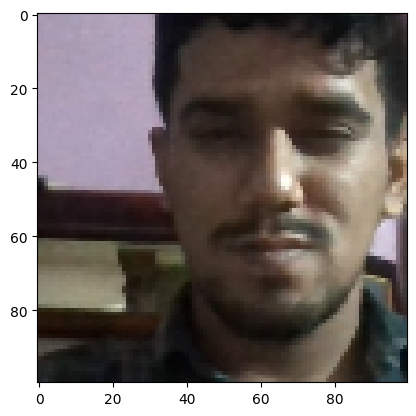

In [18]:
plt.imshow(res[0])

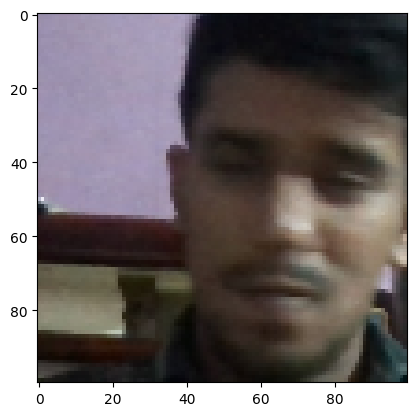

In [19]:
plt.imshow(res[1])

In [20]:
print(res[2])

1.0


In [21]:
#building databuilder pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
data

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [23]:
sampless = data.as_numpy_iterator()


In [24]:
sampless.next()

(array([[[0.65882355, 0.6117647 , 0.69803923],
         [0.6546569 , 0.60759807, 0.6938726 ],
         [0.6718137 , 0.6247549 , 0.7110294 ],
         ...,
         [0.14607844, 0.14117648, 0.1637255 ],
         [0.10759804, 0.0997549 , 0.11936274],
         [0.11470588, 0.09509804, 0.11078431]],
 
        [[0.64509803, 0.5901961 , 0.68039215],
         [0.6605392 , 0.6046569 , 0.69485295],
         [0.6816176 , 0.6279412 , 0.71004903],
         ...,
         [0.14754902, 0.14313726, 0.1620098 ],
         [0.11813726, 0.11078431, 0.12377451],
         [0.11470588, 0.10686275, 0.11862745]],
 
        [[0.65882355, 0.6039216 , 0.69411767],
         [0.65588236, 0.6       , 0.6901961 ],
         [0.6671569 , 0.60906863, 0.69779414],
         ...,
         [0.14828432, 0.14754902, 0.15759803],
         [0.11960784, 0.11813726, 0.12230392],
         [0.11764706, 0.10980392, 0.11568628]],
 
        ...,
 
        [[0.14215687, 0.14215687, 0.14411765],
         [0.12352941, 0.13039216, 0.12941

In [25]:
len(sampless.next())

3

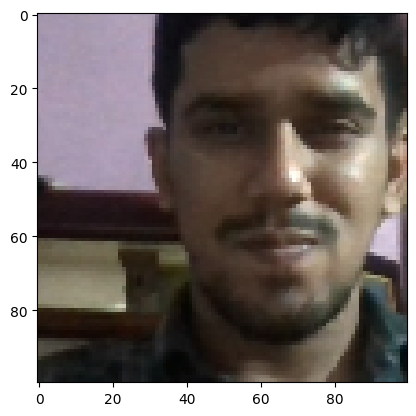

In [26]:
plt.imshow(sampless.next()[0])

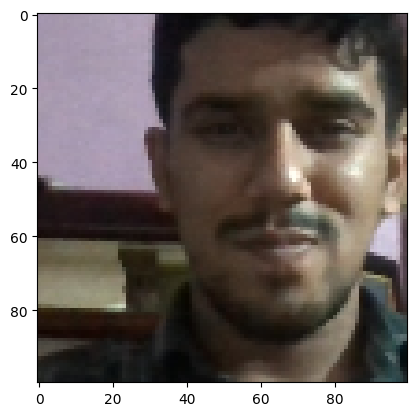

In [27]:
plt.imshow(sampless.next()[1])

In [28]:
print(sampless.next()[2])

1.0


### training partition

In [29]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
tarin_data = train_data.prefetch(8)

In [30]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [31]:
train_samples = train_data.as_numpy_iterator()

In [32]:
train_sample = train_samples.next()

In [33]:
train_sample

(array([[[[0.6041667 , 0.5531863 , 0.63161767],
          [0.6120098 , 0.56102943, 0.6394608 ],
          [0.6242647 , 0.56740195, 0.6487745 ],
          ...,
          [0.15637255, 0.15833333, 0.175     ],
          [0.19877452, 0.19191177, 0.21151961],
          [0.23137255, 0.20980392, 0.23431373]],
 
         [[0.6186274 , 0.55784315, 0.63235295],
          [0.6156863 , 0.55490196, 0.63529414],
          [0.622549  , 0.56102943, 0.64362746],
          ...,
          [0.1242647 , 0.1384804 , 0.1509804 ],
          [0.14754902, 0.14779411, 0.16544117],
          [0.17769608, 0.17083333, 0.19044118]],
 
         [[0.63235295, 0.5598039 , 0.6372549 ],
          [0.6490196 , 0.5764706 , 0.65392154],
          [0.6497549 , 0.5764706 , 0.65612745],
          ...,
          [0.10098039, 0.12181372, 0.1254902 ],
          [0.1264706 , 0.13333334, 0.14215687],
          [0.15686275, 0.15294118, 0.17254902]],
 
         ...,
 
         [[0.34411764, 0.3254902 , 0.2990196 ],
          [0.33872

In [34]:
len(train_sample)

3

In [35]:
len(train_sample[0])

16

In [36]:
len(train_sample[1])

16

In [37]:
len(train_sample[2])

16

### testing partition

In [38]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering

#### build emeding layer

In [39]:
def make_embedings():
    inp = Input(shape=(100,100,3),name="input_image")
    #first block
    c1 = Conv2D(64,(10,10),activation="relu")(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    #second block
    c2 = Conv2D(128,(7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    #third block
    c3 = Conv2D(128,(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding = 'same')(c3)
    #final embeding block
    c4 = Conv2D(256,(4,4),activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation="sigmoid")(f1)


    return Model(inputs=[inp] , outputs=[d1] , name='embeding' )

In [40]:
embeding = make_embedings()

In [41]:
embeding

In [42]:
embeding.summary()

Model: "embeding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       262

#### build distance layer

In [43]:
class L1dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
    #actual work happening
    def call(self,input_embeding,validation_embeding):
        return tf.math.abs(input_embeding-validation_embeding)

In [44]:
l1 = L1dist()

In [45]:
l1

#### making siamese model

In [46]:
def make_siamese_model():
    input_image = Input(name="input_img",shape=(100,100,3))
    validation_image = Input(name="validation_img",shape=(100,100,3))
    #combine siamese distance components
    siamese_layer = L1dist()
    siamese_layer._name = "distance"
    distances = siamese_layer(embeding(input_image),embeding(validation_image))
    #classification layer
    classification = Dense(1,activation = 'sigmoid')(distances)

    return Model(inputs=[input_image,validation_image],outputs=[classification],name='SiameseNetwork')
    

In [47]:
siamese_network = make_siamese_model()

In [48]:
siamese_network

In [49]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embeding (Functional)       (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

### setup loss and optimizer

In [50]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [51]:
opt = tf.keras.optimizers.Adam(1e-4)

### establishing checkpoints

In [52]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model = siamese_network)

### building training loop

In [53]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        #get anchor and pos/neg images
        X = batch[:2]
        #get label
        Y = batch[2]
        #forward pass
        yhat = siamese_network(X,training=True)
        #calculating loss
        loss = binary_cross_loss(Y,yhat)
    #calculate gradients
    grad = tape.gradient(loss,siamese_network.trainable_variables)
    #calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_network.trainable_variables))
    return loss

### training loop

In [54]:
def train(data,EPOCHS):
    #loop through epochs
    for epoch in range(1,EPOCHS+1):
        print("\n epoch {}/{}".format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        #loop through each batch
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        #save checkpoints
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpoint_prefix)

### train model

In [52]:
EPOCHS = 50

In [53]:
train(train_data,EPOCHS)


 epoch 1/50
27/27 [==============================] - 793s 29s/step

 epoch 2/50
27/27 [==============================] - 749s 28s/step

 epoch 3/50
27/27 [==============================] - 751s 28s/step

 epoch 4/50
27/27 [==============================] - 740s 27s/step

 epoch 5/50
27/27 [==============================] - 943s 35s/step

 epoch 6/50
27/27 [==============================] - 985s 36s/step

 epoch 7/50
27/27 [==============================] - 912s 34s/step

 epoch 8/50
27/27 [==============================] - 852s 31s/step

 epoch 9/50
27/27 [==============================] - 947s 35s/step

 epoch 10/50
27/27 [==============================] - 842s 31s/step

 epoch 11/50
27/27 [==============================] - 896s 33s/step

 epoch 12/50
27/27 [==============================] - 658s 24s/step

 epoch 13/50
27/27 [==============================] - 711s 26s/step

 epoch 14/50
27/27 [==============================] - 803s 30s/step

 epoch 15/50
27/27 [======================

# Evaluate Model

In [55]:
#imprting matric calculations
from tensorflow.keras.metrics import Precision, Recall

In [56]:
#get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [57]:
#make predictions
y_hat = siamese_network.predict([test_input,test_val])
y_hat

1/1 [==============================] - 5s 5s/step


array([[0.5014047 ],
       [0.50045764],
       [0.501031  ],
       [0.499971  ],
       [0.50025094],
       [0.50055045],
       [0.4995941 ],
       [0.50004196],
       [0.499604  ],
       [0.49991736],
       [0.50121003],
       [0.50012934],
       [0.50154865],
       [0.5002336 ],
       [0.5004257 ],
       [0.5001478 ]], dtype=float32)

In [58]:
#post processing the results
[1 if prediction>0.5 else 0 for prediction in y_hat]

# res = []
# for predictions in y_hat:
#     if predictions>0.5:
#         res.append(1)
#     else:
#         res.append(0)

[1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1]

In [59]:
y_true

array([0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.],
      dtype=float32)

In [60]:
#creating a metric object
m = Recall()
#calculating the recall value
m.update_state(y_true,y_hat)
#return recall result
m.result().numpy()

0.71428573

In [61]:
m_ = Precision()
m_.update_state(y_true,y_hat)
m_.result().numpy()

0.41666666

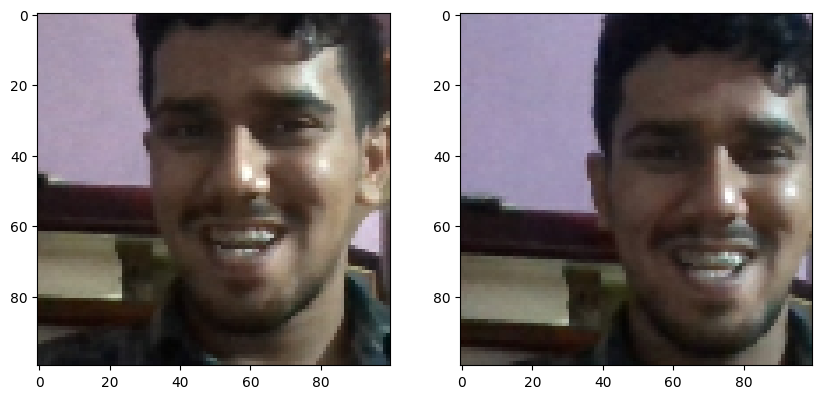

In [62]:
#visualizing results
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(test_input[4])
plt.subplot(1,2,2)
plt.imshow(test_val[4])
plt.show()

In [63]:
#saving the model

In [79]:
#save weights
siamese_network.save('siamese_model.h5')

D:\facial_recognition\facialreco\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [64]:
model = tf.keras.models.load_model('siamese_model.h5',custom_objects={'L1dist':L1dist,'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [65]:
model.predict([test_input,test_val])

1/1 [==============================] - 3s 3s/step


array([[2.13825956e-06],
       [1.17229156e-07],
       [8.79043019e-12],
       [9.99996722e-01],
       [1.00000000e+00],
       [2.94670781e-11],
       [5.32662699e-11],
       [1.00000000e+00],
       [4.43991406e-11],
       [8.63220692e-01],
       [1.09493505e-10],
       [9.73139107e-01],
       [3.70030985e-11],
       [9.99973893e-01],
       [6.88280197e-11],
       [9.99998152e-01]], dtype=float32)

In [66]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embeding (Functional)       (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Real Time Test

In [67]:
def verify(model,detection_threshold,verification_threshold):
    #detection_threshoold - metric above which prediction is considered positive
    #verification_threshold - proportion of positive prediction / total positive samples
    results = []
    for image in os.listdir(os.path.join('application_data','verification_image')):
        input_img = preprocess(os.path.join('application_data','input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data','verification_image',image))

        result = model.predict(list(np.expand_dims([input_img,validation_img],axis = 1)))
        results.append(result)

    detection = np.sum(np.array(results)>detection_threshold)
    verification = detection / len(os.listdir(os.path.join('application_data','verification_image')))
    verified = verification > verification_threshold
    return results,verified

In [68]:
# opening webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    frame = frame[120:120+250,200:200+250,:]
    cv2.imshow('verification',frame)
    if cv2.waitKey(10)& 0xFF==ord('v'):
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'),frame)
        #run verification
        results, verified = verify(model,0.5,0.5)
        print(verified)
    if cv2.waitKey(10)& 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()
        

1/1 [==============================] - 1s 508ms/step
False
